In [1]:
import time
from collections import OrderedDict

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from pandas import DataFrame

In [2]:
data = torchvision.datasets.MNIST(
    root='../data/mnist', train=True, download=True)
x = np.array(data.data)
y = np.array(data.targets)

data = torchvision.datasets.MNIST(
    root='../data/mnist', train=False, download=True)
x = np.concatenate((x, np.array(data.data)))
y = np.concatenate((y, np.array(data.targets)))

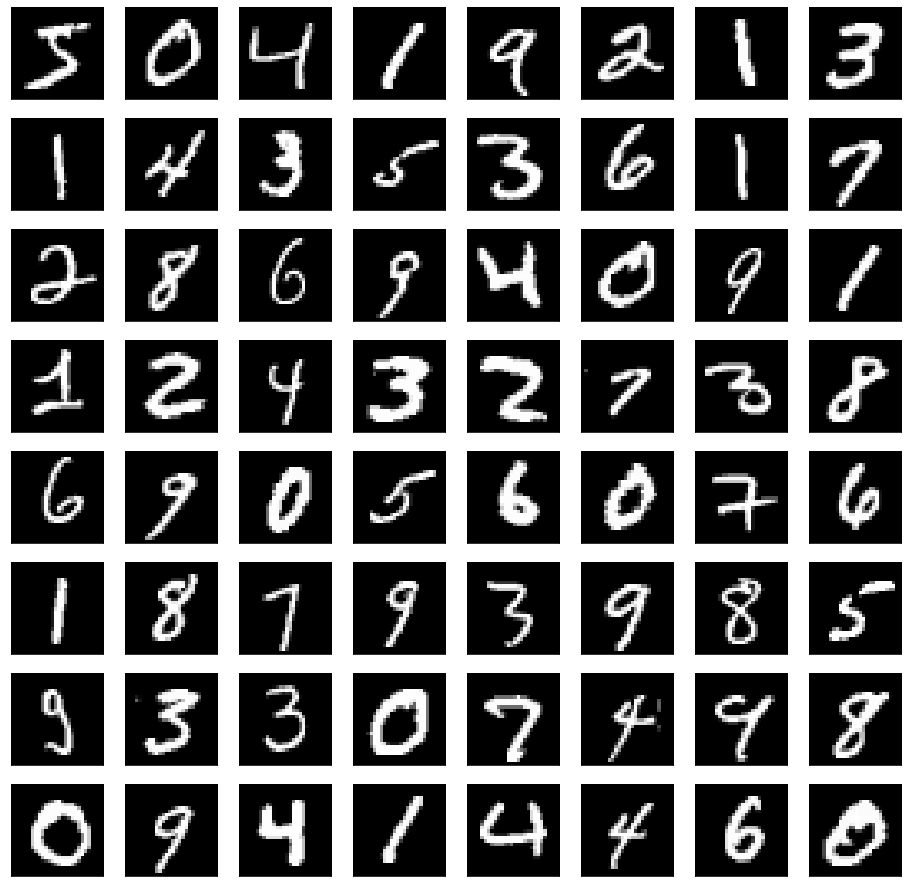

In [3]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(x[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
def plot_history(history):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['d_loss'], label='discriminator loss')
    plt.plot(history['epoch'], history['g_loss'], label='generator loss')
    plt.title('loss during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['d_acc'], label='discriminator accuracy')
    plt.title('accuracy during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

In [5]:
class GAN_:

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.loss = torch.nn.functional.binary_cross_entropy

        self.g = None
        self.d = None

    def fit(self, x, epochs, batch_size=64, shuffle=True):
        self.g.to(self.device)
        self.d.to(self.device)
        data_loader = self._build_loader_x(x, batch_size=batch_size, shuffle=shuffle)
        history = {'epoch': [], 'g_loss': [], 'd_loss': [], 'd_acc': []}
        for epoch in range(1, epochs + 1):
            self.g.train()
            self.d.train()
            start_time = time.time()
            g_loss, d_loss, d_acc = 0, 0, 0
            for real_imgs, in data_loader:
                real = torch.Tensor(real_imgs.size(0), 1).fill_(0.9).to(self.device)
                fake = torch.Tensor(real_imgs.size(0), 1).fill_(0.0).to(self.device)
                real_imgs = real_imgs.to(self.device)
                fake_imgs = self.g(torch.Tensor(
                    np.random.normal(0, 1, (real_imgs.size(0), 100))).to(self.device))
                # Train discriminator
                self.d.optimizer.zero_grad()
                real_out = self.d(real_imgs)
                fake_out = self.d(fake_imgs.detach())
                d_loss_ = (self.loss(real_out, real) + self.loss(fake_out, fake)) / 2
                d_loss_.backward()
                self.d.optimizer.step()
                # Train generator
                self.g.optimizer.zero_grad()
                g_loss_ = self.loss(self.d(fake_imgs), real)
                g_loss_.backward()
                self.g.optimizer.step()
                # Calculate metrics for batch
                g_loss += float(g_loss_) * len(real_imgs)
                d_loss += float(d_loss_) * len(real_imgs)
                d_acc += int((real_out >= 0.5).sum()) + int((fake_out < 0.5).sum())
            # Calculate metrics for epoch
            g_loss /= len(data_loader.dataset)
            d_loss /= len(data_loader.dataset)
            d_acc /= 2 * len(data_loader.dataset)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['g_loss'].append(g_loss)
            history['d_loss'].append(d_loss)
            history['d_acc'].append(d_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - g_loss: {g_loss:.4f} - d_loss: {d_loss:.4f} - d_acc: {d_acc:.4f}')

            if epoch == 1 or epoch % 20 == 0 or epoch == epochs:
                fake_imgs = self.g(torch.Tensor(
                    np.random.normal(0, 1, (16, 100))).to(self.device)).detach().cpu()
                plt.figure(figsize=(16, 4))
                for i in range(16):
                    plt.subplot(2, 8, i + 1)
                    plt.imshow(fake_imgs[i], cmap=plt.cm.gray)
                    plt.xticks([])
                    plt.yticks([])
                plt.show()

        return history

    @staticmethod
    def _build_loader_x(x, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 127.5 - 1.),
            batch_size=batch_size, shuffle=shuffle)

In [6]:
class GAN(GAN_):

    def __init__(self):
        super().__init__()

        class Generator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Linear(100, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(256),
                    torch.nn.Linear(256, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(512),
                    torch.nn.Linear(512, 1024),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(1024),
                    torch.nn.Linear(1024, 784),
                    torch.nn.Tanh(),
                ])
                self.optimizer = torch.optim.Adam(
                    self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), 28, 28)
                return x

        class Discriminator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(784, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(512, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(256, 1),
                    torch.nn.Sigmoid(),
                ])
                self.optimizer = torch.optim.Adam(
                    self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), -1)
                for layer in self.layers:
                    x = layer(x)
                return x

        self.g = Generator()
        self.d = Discriminator()

In [7]:
model = GAN()

[  1/100] 7.3s - g_loss: 0.9078 - d_loss: 0.6009 - d_acc: 0.7040


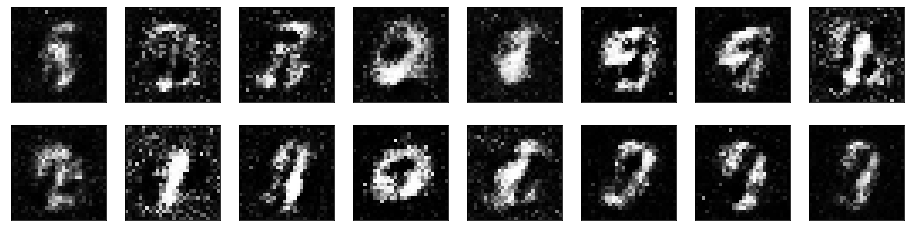

[  2/100] 6.7s - g_loss: 0.9572 - d_loss: 0.6225 - d_acc: 0.6657
[  3/100] 6.7s - g_loss: 0.9647 - d_loss: 0.6248 - d_acc: 0.6587
[  4/100] 6.7s - g_loss: 0.8888 - d_loss: 0.6536 - d_acc: 0.6141
[  5/100] 7.0s - g_loss: 0.8448 - d_loss: 0.6692 - d_acc: 0.5796
[  6/100] 6.8s - g_loss: 0.8324 - d_loss: 0.6739 - d_acc: 0.5665
[  7/100] 6.8s - g_loss: 0.8267 - d_loss: 0.6762 - d_acc: 0.5602
[  8/100] 6.7s - g_loss: 0.8255 - d_loss: 0.6770 - d_acc: 0.5584
[  9/100] 6.7s - g_loss: 0.8223 - d_loss: 0.6781 - d_acc: 0.5538
[ 10/100] 6.7s - g_loss: 0.8197 - d_loss: 0.6792 - d_acc: 0.5493
[ 11/100] 6.7s - g_loss: 0.8173 - d_loss: 0.6796 - d_acc: 0.5488
[ 12/100] 6.7s - g_loss: 0.8122 - d_loss: 0.6806 - d_acc: 0.5435
[ 13/100] 6.8s - g_loss: 0.8112 - d_loss: 0.6812 - d_acc: 0.5416
[ 14/100] 7.0s - g_loss: 0.8106 - d_loss: 0.6813 - d_acc: 0.5404
[ 15/100] 7.0s - g_loss: 0.8119 - d_loss: 0.6804 - d_acc: 0.5439
[ 16/100] 6.8s - g_loss: 0.8095 - d_loss: 0.6814 - d_acc: 0.5413
[ 17/100] 6.8s - g_loss: 

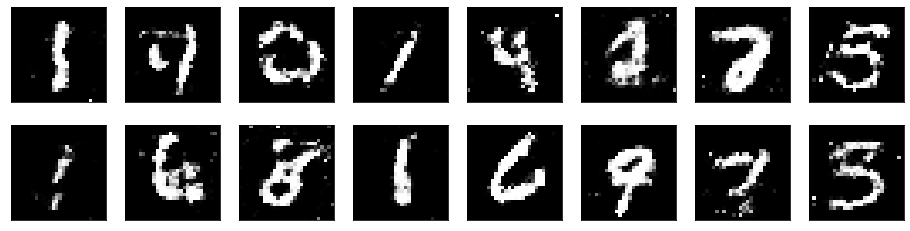

[ 21/100] 6.9s - g_loss: 0.8042 - d_loss: 0.6823 - d_acc: 0.5353
[ 22/100] 7.0s - g_loss: 0.8045 - d_loss: 0.6819 - d_acc: 0.5367
[ 23/100] 6.9s - g_loss: 0.8024 - d_loss: 0.6829 - d_acc: 0.5315
[ 24/100] 6.8s - g_loss: 0.8013 - d_loss: 0.6830 - d_acc: 0.5305
[ 25/100] 6.8s - g_loss: 0.8023 - d_loss: 0.6830 - d_acc: 0.5324
[ 26/100] 6.8s - g_loss: 0.8016 - d_loss: 0.6828 - d_acc: 0.5324
[ 27/100] 6.7s - g_loss: 0.8014 - d_loss: 0.6831 - d_acc: 0.5312
[ 28/100] 6.8s - g_loss: 0.7995 - d_loss: 0.6829 - d_acc: 0.5312
[ 29/100] 6.8s - g_loss: 0.7999 - d_loss: 0.6836 - d_acc: 0.5267
[ 30/100] 6.7s - g_loss: 0.7989 - d_loss: 0.6833 - d_acc: 0.5291
[ 31/100] 7.0s - g_loss: 0.7994 - d_loss: 0.6836 - d_acc: 0.5282
[ 32/100] 6.7s - g_loss: 0.7981 - d_loss: 0.6836 - d_acc: 0.5274
[ 33/100] 6.8s - g_loss: 0.7982 - d_loss: 0.6837 - d_acc: 0.5279
[ 34/100] 6.8s - g_loss: 0.7977 - d_loss: 0.6839 - d_acc: 0.5260
[ 35/100] 6.7s - g_loss: 0.7977 - d_loss: 0.6837 - d_acc: 0.5275
[ 36/100] 6.7s - g_loss: 

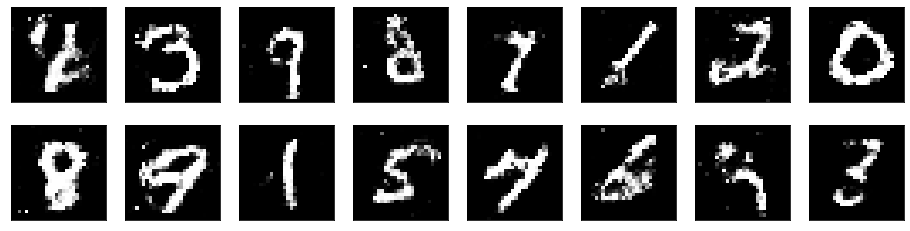

[ 41/100] 7.0s - g_loss: 0.7953 - d_loss: 0.6844 - d_acc: 0.5241
[ 42/100] 6.9s - g_loss: 0.7964 - d_loss: 0.6844 - d_acc: 0.5237
[ 43/100] 6.9s - g_loss: 0.7968 - d_loss: 0.6840 - d_acc: 0.5258
[ 44/100] 6.8s - g_loss: 0.7967 - d_loss: 0.6840 - d_acc: 0.5248
[ 45/100] 6.9s - g_loss: 0.7953 - d_loss: 0.6843 - d_acc: 0.5231
[ 46/100] 6.8s - g_loss: 0.7948 - d_loss: 0.6846 - d_acc: 0.5232
[ 47/100] 6.7s - g_loss: 0.7953 - d_loss: 0.6844 - d_acc: 0.5224
[ 48/100] 6.8s - g_loss: 0.7935 - d_loss: 0.6849 - d_acc: 0.5207
[ 49/100] 7.0s - g_loss: 0.7953 - d_loss: 0.6844 - d_acc: 0.5234
[ 50/100] 6.8s - g_loss: 0.7940 - d_loss: 0.6847 - d_acc: 0.5216
[ 51/100] 6.8s - g_loss: 0.7939 - d_loss: 0.6847 - d_acc: 0.5219
[ 52/100] 6.8s - g_loss: 0.7944 - d_loss: 0.6847 - d_acc: 0.5221
[ 53/100] 6.8s - g_loss: 0.7945 - d_loss: 0.6846 - d_acc: 0.5223
[ 54/100] 6.8s - g_loss: 0.7947 - d_loss: 0.6850 - d_acc: 0.5204
[ 55/100] 6.8s - g_loss: 0.7942 - d_loss: 0.6848 - d_acc: 0.5211
[ 56/100] 6.8s - g_loss: 

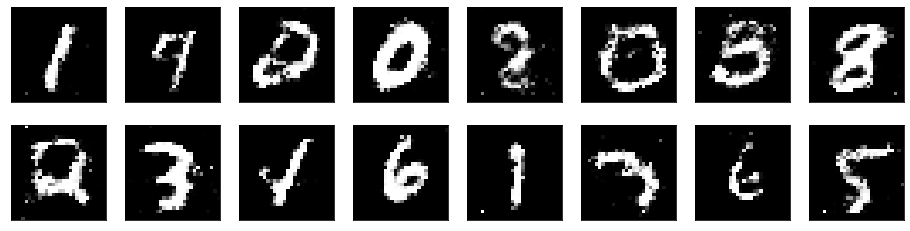

[ 61/100] 6.9s - g_loss: 0.7930 - d_loss: 0.6853 - d_acc: 0.5187
[ 62/100] 6.8s - g_loss: 0.7921 - d_loss: 0.6853 - d_acc: 0.5180
[ 63/100] 6.8s - g_loss: 0.7935 - d_loss: 0.6851 - d_acc: 0.5193
[ 64/100] 6.9s - g_loss: 0.7929 - d_loss: 0.6850 - d_acc: 0.5193
[ 65/100] 6.7s - g_loss: 0.7939 - d_loss: 0.6848 - d_acc: 0.5209
[ 66/100] 6.9s - g_loss: 0.7931 - d_loss: 0.6852 - d_acc: 0.5200
[ 67/100] 6.8s - g_loss: 0.7926 - d_loss: 0.6852 - d_acc: 0.5195
[ 68/100] 6.8s - g_loss: 0.7918 - d_loss: 0.6857 - d_acc: 0.5155
[ 69/100] 6.8s - g_loss: 0.7926 - d_loss: 0.6852 - d_acc: 0.5185
[ 70/100] 6.8s - g_loss: 0.7927 - d_loss: 0.6852 - d_acc: 0.5195
[ 71/100] 6.8s - g_loss: 0.7925 - d_loss: 0.6849 - d_acc: 0.5202
[ 72/100] 6.9s - g_loss: 0.7927 - d_loss: 0.6853 - d_acc: 0.5194
[ 73/100] 6.8s - g_loss: 0.7923 - d_loss: 0.6851 - d_acc: 0.5204
[ 74/100] 6.8s - g_loss: 0.7923 - d_loss: 0.6855 - d_acc: 0.5190
[ 75/100] 7.0s - g_loss: 0.7921 - d_loss: 0.6852 - d_acc: 0.5187
[ 76/100] 6.7s - g_loss: 

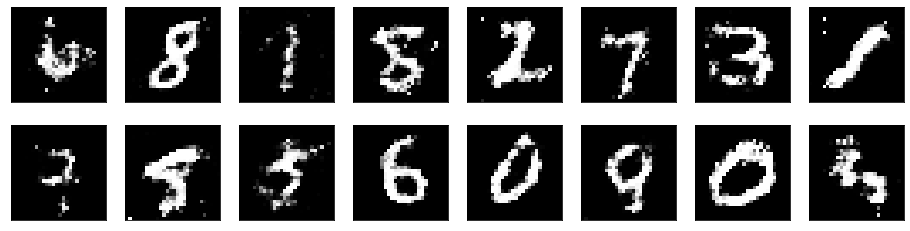

[ 81/100] 7.0s - g_loss: 0.7913 - d_loss: 0.6858 - d_acc: 0.5155
[ 82/100] 6.8s - g_loss: 0.7915 - d_loss: 0.6857 - d_acc: 0.5166
[ 83/100] 6.8s - g_loss: 0.7912 - d_loss: 0.6856 - d_acc: 0.5185
[ 84/100] 7.1s - g_loss: 0.7923 - d_loss: 0.6857 - d_acc: 0.5180
[ 85/100] 6.8s - g_loss: 0.7911 - d_loss: 0.6854 - d_acc: 0.5168
[ 86/100] 6.8s - g_loss: 0.7919 - d_loss: 0.6857 - d_acc: 0.5179
[ 87/100] 6.8s - g_loss: 0.7921 - d_loss: 0.6854 - d_acc: 0.5177
[ 88/100] 6.9s - g_loss: 0.7914 - d_loss: 0.6857 - d_acc: 0.5152
[ 89/100] 6.8s - g_loss: 0.7909 - d_loss: 0.6858 - d_acc: 0.5165
[ 90/100] 6.8s - g_loss: 0.7906 - d_loss: 0.6859 - d_acc: 0.5159
[ 91/100] 6.8s - g_loss: 0.7908 - d_loss: 0.6859 - d_acc: 0.5159
[ 92/100] 6.8s - g_loss: 0.7908 - d_loss: 0.6859 - d_acc: 0.5168
[ 93/100] 7.0s - g_loss: 0.7915 - d_loss: 0.6855 - d_acc: 0.5173
[ 94/100] 6.9s - g_loss: 0.7911 - d_loss: 0.6856 - d_acc: 0.5175
[ 95/100] 6.8s - g_loss: 0.7896 - d_loss: 0.6865 - d_acc: 0.5129
[ 96/100] 6.8s - g_loss: 

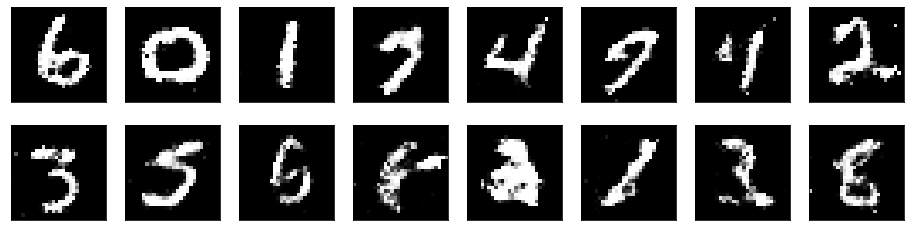

In [8]:
history = model.fit(x, epochs=100)

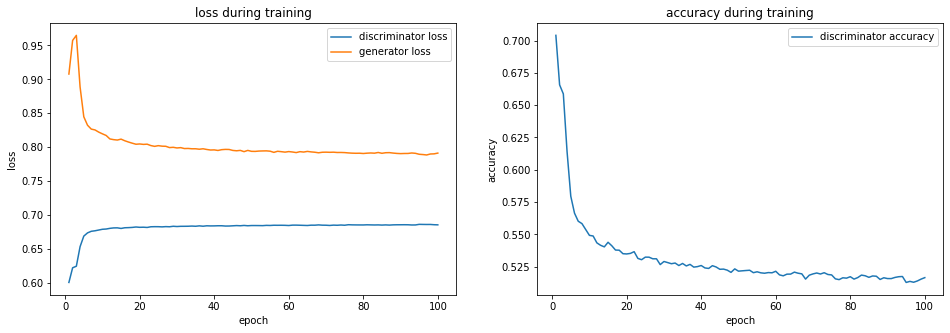

In [9]:
plot_history(history)

In [10]:
class DCGAN(GAN_):

    def __init__(self):
        super().__init__()

        class Generator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.ConvTranspose2d(100, 512, 4),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=2),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
                    torch.nn.Tanh(),
                ])
                self.optimizer = torch.optim.Adam(
                    self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), x.size(1), 1, 1)
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), 28, 28)
                return x

        class Discriminator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Conv2d(1, 16, 4, stride=2, padding=1),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Conv2d(16, 32, 4, stride=2, padding=2),
                    torch.nn.BatchNorm2d(32),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Conv2d(32, 64, 4, stride=2, padding=1),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Conv2d(64, 1, 4),
                    torch.nn.Sigmoid(),
                ])
                self.optimizer = torch.optim.Adam(
                    self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), 1, 28, 28)
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), -1)
                return x

        self.g = Generator()
        self.d = Discriminator()

In [11]:
model = DCGAN()

[  1/100] 41.9s - g_loss: 0.7986 - d_loss: 0.6891 - d_acc: 0.5063


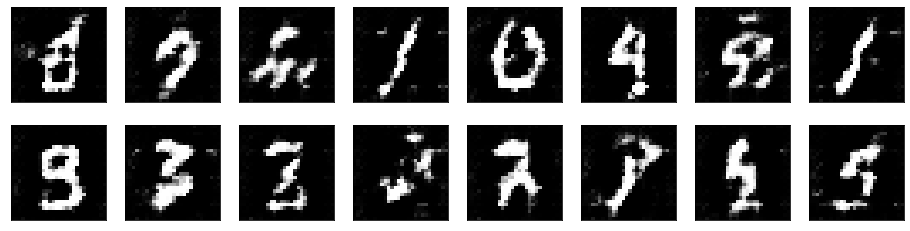

[  2/100] 41.4s - g_loss: 0.7895 - d_loss: 0.6868 - d_acc: 0.5073
[  3/100] 41.4s - g_loss: 0.7869 - d_loss: 0.6873 - d_acc: 0.5046
[  4/100] 41.1s - g_loss: 0.7853 - d_loss: 0.6878 - d_acc: 0.5024
[  5/100] 41.8s - g_loss: 0.7840 - d_loss: 0.6879 - d_acc: 0.5023
[  6/100] 41.5s - g_loss: 0.7825 - d_loss: 0.6879 - d_acc: 0.5023
[  7/100] 41.0s - g_loss: 0.7828 - d_loss: 0.6884 - d_acc: 0.5006
[  8/100] 41.4s - g_loss: 0.7816 - d_loss: 0.6883 - d_acc: 0.5010
[  9/100] 41.9s - g_loss: 0.7816 - d_loss: 0.6880 - d_acc: 0.5008
[ 10/100] 40.8s - g_loss: 0.7815 - d_loss: 0.6882 - d_acc: 0.5010
[ 11/100] 41.0s - g_loss: 0.7814 - d_loss: 0.6883 - d_acc: 0.5006
[ 12/100] 41.0s - g_loss: 0.7808 - d_loss: 0.6883 - d_acc: 0.5002
[ 13/100] 40.9s - g_loss: 0.7800 - d_loss: 0.6884 - d_acc: 0.5000
[ 14/100] 41.0s - g_loss: 0.7800 - d_loss: 0.6883 - d_acc: 0.5003
[ 15/100] 41.0s - g_loss: 0.7808 - d_loss: 0.6882 - d_acc: 0.5001
[ 16/100] 40.9s - g_loss: 0.7799 - d_loss: 0.6885 - d_acc: 0.4999
[ 17/100] 

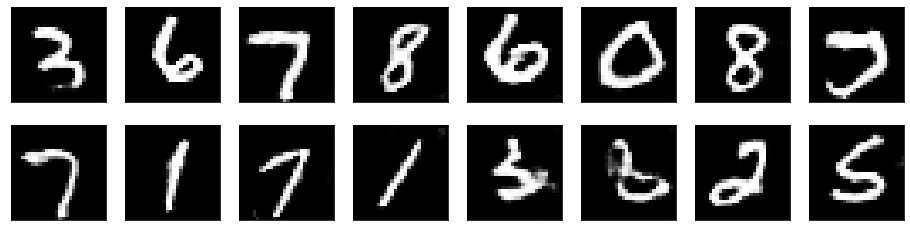

[ 21/100] 41.1s - g_loss: 0.7799 - d_loss: 0.6883 - d_acc: 0.5002
[ 22/100] 41.5s - g_loss: 0.7801 - d_loss: 0.6884 - d_acc: 0.5001
[ 23/100] 40.9s - g_loss: 0.7799 - d_loss: 0.6884 - d_acc: 0.5000
[ 24/100] 41.2s - g_loss: 0.7796 - d_loss: 0.6883 - d_acc: 0.5000
[ 25/100] 41.0s - g_loss: 0.7800 - d_loss: 0.6883 - d_acc: 0.5000
[ 26/100] 40.7s - g_loss: 0.7792 - d_loss: 0.6884 - d_acc: 0.5000
[ 27/100] 41.8s - g_loss: 0.7788 - d_loss: 0.6884 - d_acc: 0.5000
[ 28/100] 40.1s - g_loss: 0.7793 - d_loss: 0.6882 - d_acc: 0.5000
[ 29/100] 41.4s - g_loss: 0.7796 - d_loss: 0.6884 - d_acc: 0.5000
[ 30/100] 42.5s - g_loss: 0.7795 - d_loss: 0.6883 - d_acc: 0.5000
[ 31/100] 41.9s - g_loss: 0.7798 - d_loss: 0.6881 - d_acc: 0.5000
[ 32/100] 40.9s - g_loss: 0.7790 - d_loss: 0.6882 - d_acc: 0.4999
[ 33/100] 40.9s - g_loss: 0.7788 - d_loss: 0.6883 - d_acc: 0.5000
[ 34/100] 41.0s - g_loss: 0.7792 - d_loss: 0.6884 - d_acc: 0.5000
[ 35/100] 40.7s - g_loss: 0.7795 - d_loss: 0.6882 - d_acc: 0.5000
[ 36/100] 

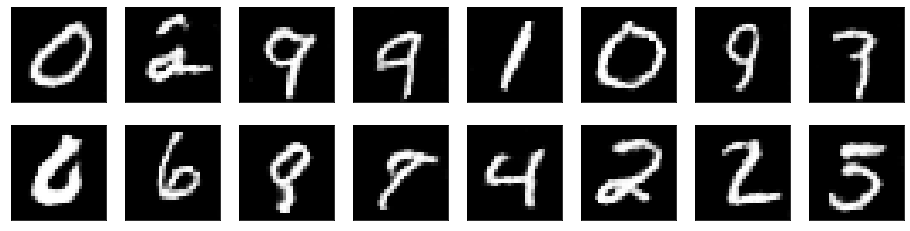

[ 41/100] 43.2s - g_loss: 0.7790 - d_loss: 0.6883 - d_acc: 0.5000
[ 42/100] 42.6s - g_loss: 0.7792 - d_loss: 0.6882 - d_acc: 0.5000
[ 43/100] 38.1s - g_loss: 0.7788 - d_loss: 0.6882 - d_acc: 0.5000
[ 44/100] 42.2s - g_loss: 0.7794 - d_loss: 0.6881 - d_acc: 0.5000
[ 45/100] 40.8s - g_loss: 0.7796 - d_loss: 0.6882 - d_acc: 0.5000
[ 46/100] 41.0s - g_loss: 0.7793 - d_loss: 0.6882 - d_acc: 0.5000
[ 47/100] 40.9s - g_loss: 0.7793 - d_loss: 0.6881 - d_acc: 0.5000
[ 48/100] 40.7s - g_loss: 0.7796 - d_loss: 0.6881 - d_acc: 0.5000
[ 49/100] 40.9s - g_loss: 0.7785 - d_loss: 0.6883 - d_acc: 0.5000
[ 50/100] 42.0s - g_loss: 0.7794 - d_loss: 0.6882 - d_acc: 0.5000
[ 51/100] 42.8s - g_loss: 0.7789 - d_loss: 0.6884 - d_acc: 0.5000
[ 52/100] 40.9s - g_loss: 0.7790 - d_loss: 0.6881 - d_acc: 0.5000
[ 53/100] 40.8s - g_loss: 0.7791 - d_loss: 0.6881 - d_acc: 0.5000
[ 54/100] 40.7s - g_loss: 0.7797 - d_loss: 0.6884 - d_acc: 0.5000
[ 55/100] 41.0s - g_loss: 0.7793 - d_loss: 0.6881 - d_acc: 0.5000
[ 56/100] 

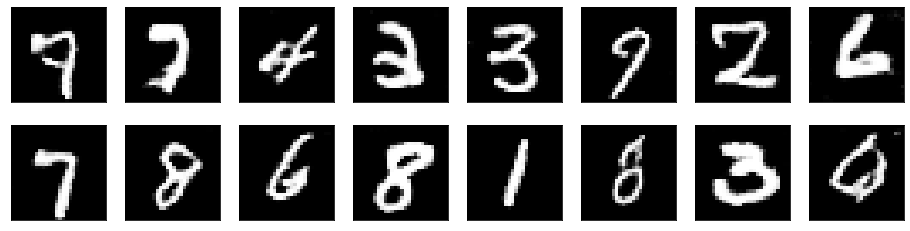

[ 61/100] 40.8s - g_loss: 0.7790 - d_loss: 0.6885 - d_acc: 0.5000
[ 62/100] 41.0s - g_loss: 0.7791 - d_loss: 0.6882 - d_acc: 0.5000
[ 63/100] 41.4s - g_loss: 0.7791 - d_loss: 0.6882 - d_acc: 0.5000
[ 64/100] 42.6s - g_loss: 0.7793 - d_loss: 0.6878 - d_acc: 0.5000
[ 65/100] 42.7s - g_loss: 0.7795 - d_loss: 0.6884 - d_acc: 0.5000
[ 66/100] 43.2s - g_loss: 0.7793 - d_loss: 0.6882 - d_acc: 0.5000
[ 67/100] 41.0s - g_loss: 0.7790 - d_loss: 0.6882 - d_acc: 0.5000
[ 68/100] 39.4s - g_loss: 0.7786 - d_loss: 0.6882 - d_acc: 0.5000
[ 69/100] 41.1s - g_loss: 0.7793 - d_loss: 0.6882 - d_acc: 0.5000
[ 70/100] 40.9s - g_loss: 0.7791 - d_loss: 0.6882 - d_acc: 0.5000
[ 71/100] 41.1s - g_loss: 0.7785 - d_loss: 0.6881 - d_acc: 0.5000
[ 72/100] 41.2s - g_loss: 0.7785 - d_loss: 0.6881 - d_acc: 0.5000
[ 73/100] 41.3s - g_loss: 0.7790 - d_loss: 0.6882 - d_acc: 0.5000
[ 74/100] 40.9s - g_loss: 0.7791 - d_loss: 0.6882 - d_acc: 0.5000
[ 75/100] 42.6s - g_loss: 0.7789 - d_loss: 0.6882 - d_acc: 0.5000
[ 76/100] 

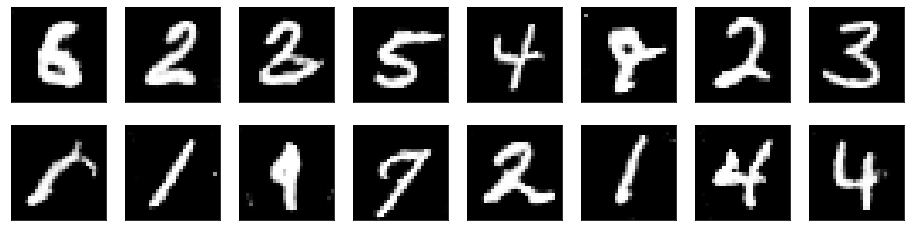

[ 81/100] 41.1s - g_loss: 0.7787 - d_loss: 0.6882 - d_acc: 0.5000
[ 82/100] 40.9s - g_loss: 0.7787 - d_loss: 0.6883 - d_acc: 0.5000
[ 83/100] 41.3s - g_loss: 0.7794 - d_loss: 0.6880 - d_acc: 0.5000
[ 84/100] 41.0s - g_loss: 0.7788 - d_loss: 0.6883 - d_acc: 0.5000
[ 85/100] 40.9s - g_loss: 0.7792 - d_loss: 0.6882 - d_acc: 0.5000
[ 86/100] 40.7s - g_loss: 0.7791 - d_loss: 0.6882 - d_acc: 0.5000
[ 87/100] 40.9s - g_loss: 0.7787 - d_loss: 0.6882 - d_acc: 0.5000
[ 88/100] 41.1s - g_loss: 0.7788 - d_loss: 0.6882 - d_acc: 0.5000
[ 89/100] 40.7s - g_loss: 0.7787 - d_loss: 0.6882 - d_acc: 0.5000
[ 90/100] 40.9s - g_loss: 0.7785 - d_loss: 0.6883 - d_acc: 0.5000
[ 91/100] 40.9s - g_loss: 0.7788 - d_loss: 0.6883 - d_acc: 0.5000
[ 92/100] 40.9s - g_loss: 0.7788 - d_loss: 0.6882 - d_acc: 0.5000
[ 93/100] 41.1s - g_loss: 0.7787 - d_loss: 0.6882 - d_acc: 0.5000
[ 94/100] 41.0s - g_loss: 0.7788 - d_loss: 0.6882 - d_acc: 0.5000
[ 95/100] 41.1s - g_loss: 0.7789 - d_loss: 0.6881 - d_acc: 0.5000
[ 96/100] 

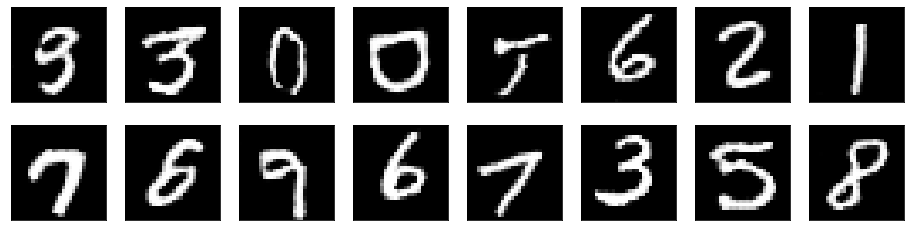

In [12]:
history = model.fit(x, epochs=100)

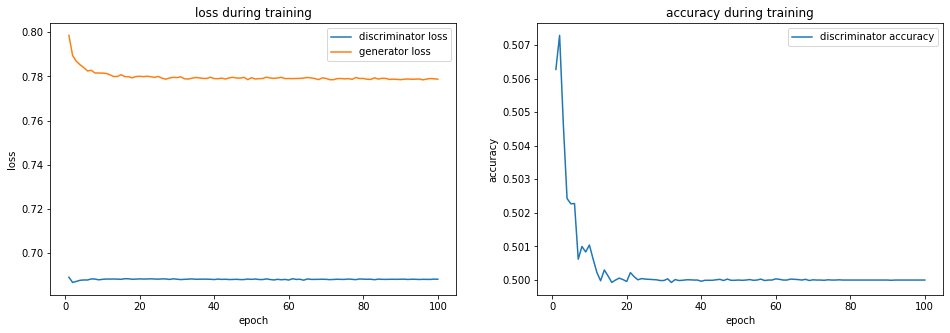

In [13]:
plot_history(history)